## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from tqdm import tqdm

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = f = open('complaints-2021-05-14_08_16.json','r')
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
df.columns.values


array(['_index', '_type', '_id', '_score', '_source.tags',
       '_source.zip_code', '_source.complaint_id', '_source.issue',
       '_source.date_received', '_source.state',
       '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company',
       '_source.submitted_via', '_source.date_sent_to_company',
       '_source.company_public_response', '_source.sub_product',
       '_source.timely', '_source.complaint_what_happened',
       '_source.sub_issue', '_source.consumer_consent_provided'],
      dtype=object)

In [5]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags',
       'zipcode', 'complaintid', 'issue',
       'datereceived', 'state',
       'consumerdisputed', 'product',
       'companyresponse', 'company',
       'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct',
       'timely', 'complaintwhathappened',
       'subissue', 'consumerconsentprovided']

df.columns.values

array(['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid',
       'issue', 'datereceived', 'state', 'consumerdisputed', 'product',
       'companyresponse', 'company', 'submittedvia', 'datesenttocompany',
       'companypublicresponse', 'subproduct', 'timely',
       'complaintwhathappened', 'subissue', 'consumerconsentprovided'],
      dtype=object)

In [6]:
#Assign nan in place of blanks in the complaints column
df['complaintwhathappened']  = df['complaintwhathappened'].replace(r'^\s*$', np.nan, regex=True)
df['complaintwhathappened']  = df['complaintwhathappened'].replace('', np.nan)
df['complaintwhathappened'].isnull().sum()

57241

In [7]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaintwhathappened'], inplace=True)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [8]:
# function to clean the text and remove all the unnecessary elements.
def cleancomplaints(x):
    x = x.lower()
    x = re.sub("[\[].*?[\]]", "", x) #Alternative = \[.*?\]
    x = re.sub(r'[^\w\s]', '', x)
    x = re.sub("\S*\d\S*", "", x)
    return x

df['complaintwhathappened'] = df['complaintwhathappened'].apply(cleancomplaints)

In [9]:
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])
#function to Lemmatize the texts
normal_sentence = []
lemmatized_with_pos = []
pos_of_each_word = []
for sentence in tqdm(df['complaintwhathappened'].values.tolist()):
    normal_sentence.append(sentence)
    doc = nlp(sentence)
    temp_lemma = []
    temp_pos = []
    for tok in doc:
        temp_lemma.append(tok.lemma_)
        temp_pos.append(tok.pos_)
    lemmatized_with_pos.append(' '.join(temp_lemma))
    pos_of_each_word.append(' '.join(temp_pos))


100%|████████████████████████████████████████████████████████████████████████████| 21072/21072 [03:32<00:00, 99.02it/s]


In [113]:
df_list = []
for i in range(len(normal_sentence)):
    df_list.append([normal_sentence[i],lemmatized_with_pos[i],pos_of_each_word[i]])

In [114]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame(df_list,columns=['NormalComplaints','LemmatizedComplaints','POS'])

In [115]:
df_clean

,NormalComplaints,LemmatizedComplaints,POS
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a ...,ADJ NOUN DET NOUN AUX PROPN PROPN CCONJ PRON VERB PRON SCONJ PRON VERB VERB PRON VERB DET NOUN A...
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- annivers...,PRON VERB DET PROPN PROPN PROPN ADP SPACE CCONJ AUX VERB ADP DET NOUN PRON AUX DET NOUN DET NOUN...
2,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit -PRON- identity without ...,PROPN PROPN AUX VERB ADP SPACE ADV ADJ NOUN AUX AUX VERB DET NOUN ADP DET NOUN PART ADV VERB NOU...
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards t...,ADP SPACE SCONJ VERB PART VERB DET PROPN SPACE PROPN SPACE NOUN PRON VERB ADP DET NOUN ADP SPACE...
4,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund c...,DET ADJ NOUN VERB PRON VERB ADP SPACE PRON VERB PRON ADP DET NOUN NOUN ADP NOUN PROPN DET PROPN ...
...,...,...,...
21067,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,ADP AUX DET NOUN NOUN NOUN ADP ADV ADP DET NOUN AUX VERB ADJ NOUN ADP VERB ADJ NOUN NOUN ADP PRO...
21068,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx i call chas -PRON- xxxx xxxx visa credit card provider and ask how to make...,ADP PROPN PROPN PRON VERB PROPN DET PROPN PROPN PROPN PROPN NOUN NOUN CCONJ VERB ADV PART VERB D...
21069,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,i be not familiar with xxxx pay and do not understand the great risk this provide to consumer i ...,PRON AUX PART ADJ ADP PROPN PROPN CCONJ AUX PART VERB DET ADJ NOUN DET VERB ADP NOUN PRON VERB D...
21070,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,i have have flawless credit for yrs -PRON- have have chase credit card chase freedom speci...,PRON AUX VERB ADJ NOUN ADP SPACE INTJ PRON VERB AUX PROPN NOUN NOUN SPACE PROPN NOUN SPACE ADV S...


In [117]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
lemmatized_only_Nouns = []
for i in tqdm(range(len(lemmatized_with_pos))):
    temp = []
    lemmatized_sentence = lemmatized_with_pos[i].split()
    pos = pos_of_each_word[i].split()
    for j in range(len(lemmatized_sentence)):
        if(pos[j] == "NOUN" or pos[j] == "PROPN"):
            temp.append(lemmatized_sentence[j])
    lemmatized_only_Nouns.append(' '.join(temp))
    
df_clean['LemmatizedOnlyNouns'] = lemmatized_only_Nouns
df_clean

100%|█████████████████████████████████████████████████████████████████████████| 21072/21072 [00:01<00:00, 11225.35it/s]


,NormalComplaints,LemmatizedComplaints,POS,LemmatizedOnlyNouns
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a ...,ADJ NOUN DET NOUN AUX PROPN PROPN CCONJ PRON VERB PRON SCONJ PRON VERB VERB PRON VERB DET NOUN A...,morning name xxxx xxxx stop chase bank cardmember service and what be validate i month -PRON- ha...
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,i upgrade -PRON- xxxx xxxx card in and be tell by the agent who do the upgrade -PRON- annivers...,PRON VERB DET PROPN PROPN PROPN ADP SPACE CCONJ AUX VERB ADP DET NOUN PRON AUX DET NOUN DET NOUN...,xxxx xxxx card who -PRON- date would be in to xxxx change from xxxxxxxx xxxxxxxx -PRON- have the...
2,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit -PRON- identity without ...,PROPN PROPN AUX VERB ADP SPACE ADV ADJ NOUN AUX AUX VERB DET NOUN ADP DET NOUN PART ADV VERB NOU...,chase card have without to do without of
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a xxxx xxxx ticket i come across an offer for to be apply towards t...,ADP SPACE SCONJ VERB PART VERB DET PROPN SPACE PROPN SPACE NOUN PRON VERB ADP DET NOUN ADP SPACE...,xxxx i across be for in -PRON- and than the could make to immediately contact more than i by tha...
4,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund c...,DET ADJ NOUN VERB PRON VERB ADP SPACE PRON VERB PRON ADP DET NOUN NOUN ADP NOUN PROPN DET PROPN ...,son account after clear -PRON- bank close never -PRON- check be be bank refuse -PRON- call time ...
...,...,...,...,...
21067,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,ADP AUX DET NOUN NOUN NOUN ADP ADV ADP DET NOUN AUX VERB ADJ NOUN ADP VERB ADJ NOUN NOUN ADP PRO...,chase card customer decade solicitation credit card chase airline mile and point be no year than...
21068,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday xxxxxxxx i call chas -PRON- xxxx xxxx visa credit card provider and ask how to make...,ADP PROPN PROPN PRON VERB PROPN DET PROPN PROPN PROPN PROPN NOUN NOUN CCONJ VERB ADV PART VERB D...,wednesday xxxxxxxx chas xxxx xxxx visa credit card provider claim purchase protection benefit xx...
21069,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,i be not familiar with xxxx pay and do not understand the great risk this provide to consumer i ...,PRON AUX PART ADJ ADP PROPN PROPN CCONJ AUX PART VERB DET ADJ NOUN DET VERB ADP NOUN PRON VERB D...,xxxx pay risk consumer chase bank app chase and and except have and the of look of with link wit...
21070,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,i have have flawless credit for yrs -PRON- have have chase credit card chase freedom speci...,PRON AUX VERB ADJ NOUN ADP SPACE INTJ PRON VERB AUX PROPN NOUN NOUN SPACE PROPN NOUN SPACE ADV S...,credit credit card chase specifically since problem have -PRON- life have i do chase freedom do ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0.5, 1.0, "Visualising the data according to the 'Complaint' character length")

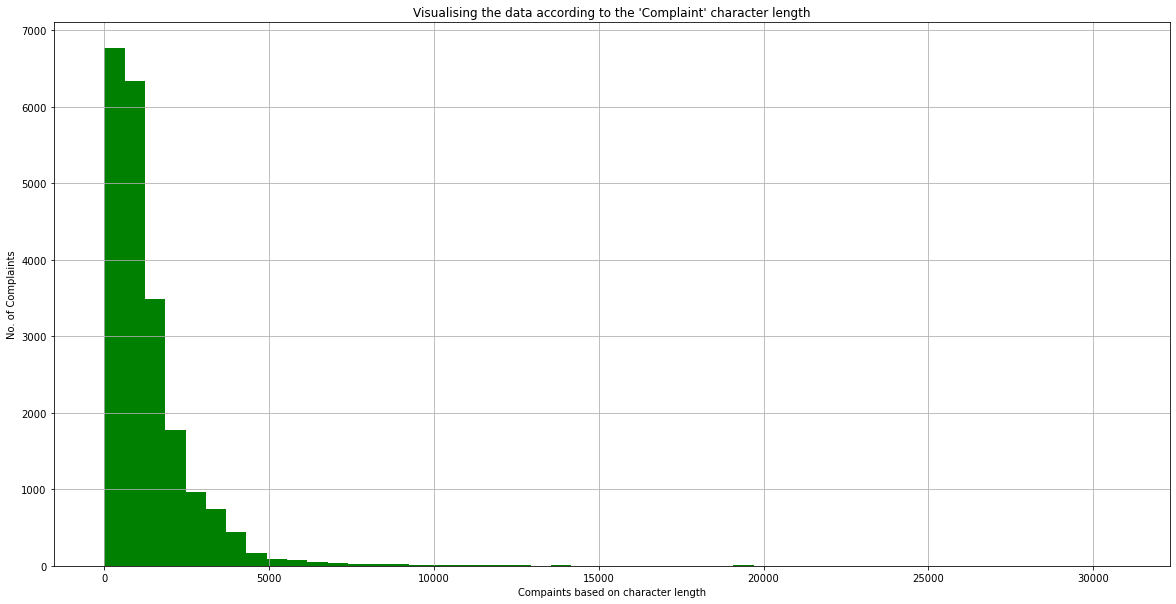

In [95]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_size = pd.DataFrame({"size":[len(x) for x in df_clean['NormalComplaints']]})
fig = plt.figure(figsize = (20, 10))
df_size['size'].hist( bins=50, color='green')
plt.xlabel("Compaints based on character length")
plt.ylabel("No. of Complaints")
plt.title("Visualising the data according to the 'Complaint' character length")

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [118]:
df_clean['LemmatizedOnlyNouns'] = df_clean['LemmatizedOnlyNouns'].str.replace(r'x+', '', regex=True)
df_clean['LemmatizedComplaints'] = df_clean['LemmatizedComplaints'].str.replace(r'x+', '', regex=True)

In [119]:
#All masked texts has been removed
pd.options.display.max_colwidth = 100
df_clean

,NormalComplaints,LemmatizedComplaints,POS,LemmatizedOnlyNouns
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning -PRON- name be and i appreciate -PRON- if -PRON- could help -PRON- put a stop to ...,ADJ NOUN DET NOUN AUX PROPN PROPN CCONJ PRON VERB PRON SCONJ PRON VERB VERB PRON VERB DET NOUN A...,morning name stop chase bank cardmember service and what be validate i month -PRON- have this ...
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,i upgrade -PRON- card in and be tell by the agent who do the upgrade -PRON- anniversary date...,PRON VERB DET PROPN PROPN PROPN ADP SPACE CCONJ AUX VERB ADP DET NOUN PRON AUX DET NOUN DET NOUN...,card who -PRON- date would be in to change from -PRON- have the the be
2,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit -PRON- identity without ...,PROPN PROPN AUX VERB ADP SPACE ADV ADJ NOUN AUX AUX VERB DET NOUN ADP DET NOUN PART ADV VERB NOU...,chase card have without to do without of
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a ticket i come across an offer for to be apply towards the ticke...,ADP SPACE SCONJ VERB PART VERB DET PROPN SPACE PROPN SPACE NOUN PRON VERB ADP DET NOUN ADP SPACE...,i across be for in -PRON- and than the could make to immediately contact more than i by that -P...
4,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund c...,DET ADJ NOUN VERB PRON VERB ADP SPACE PRON VERB PRON ADP DET NOUN NOUN ADP NOUN PROPN DET PROPN ...,son account after clear -PRON- bank close never -PRON- check be be bank refuse -PRON- call time ...
...,...,...,...,...
21067,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,ADP AUX DET NOUN NOUN NOUN ADP ADV ADP DET NOUN AUX VERB ADJ NOUN ADP VERB ADJ NOUN NOUN ADP PRO...,chase card customer decade solicitation credit card chase airline mile and point be no year than...
21068,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday i call chas -PRON- visa credit card provider and ask how to make a claim under -...,ADP PROPN PROPN PRON VERB PROPN DET PROPN PROPN PROPN PROPN NOUN NOUN CCONJ VERB ADV PART VERB D...,wednesday chas visa credit card provider claim purchase protection benefit school tetbook y...
21069,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,i be not familiar with pay and do not understand the great risk this provide to consumer i beli...,PRON AUX PART ADJ ADP PROPN PROPN CCONJ AUX PART VERB DET ADJ NOUN DET VERB ADP NOUN PRON VERB D...,pay risk consumer chase bank app chase and and ecept have and the of look of with link without ...
21070,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,i have have flawless credit for yrs -PRON- have have chase credit card chase freedom speci...,PRON AUX VERB ADJ NOUN ADP SPACE INTJ PRON VERB AUX PROPN NOUN NOUN SPACE PROPN NOUN SPACE ADV S...,credit credit card chase specifically since problem have -PRON- life have i do chase freedom do ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [120]:
ConsideredComplaints = df_clean['LemmatizedOnlyNouns'].values.tolist()
#initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english',max_df=0.95,min_df=2)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [121]:
#create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(ConsideredComplaints)
pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names())

C:\Users\Tasheer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,aa,aarp,abandon,abate,abatement,abide,ability,able,abovementioned,abovenamed,...,york,young,yr,yrs,ytd,yup,zero,zip,zombie,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

The following actions are being performed:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [122]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [123]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state = 40) #write your code here

In [124]:
nmf_model.fit(dtm)
W = nmf_model.transform(dtm)  # Document-topic matrix
H = nmf_model.components_  # Topic-term matrix
len(tfidf.get_feature_names())

C:\Users\Tasheer\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

C:\Users\Tasheer\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



7064

In [125]:
#Print the Top15 words for each of the topics
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,pron,tell,say,receive,chase,send,make,ask,pay,state,claim,day,charge,contact,use
Topic 2,card,credit,chase,charge,balance,service,company,purchase,freedom,visa,time,score,limit,dispute,statement
Topic 3,account,bank,chase,check,checking,money,fund,fee,deposit,number,transaction,saving,branch,overdraft,fraud
Topic 4,payment,loan,mortgage,chase,modification,month,home,time,auto,year,bank,morgan,pay,balance,jp
Topic 5,report,credit,inquiry,company,jpmcb,theft,information,reporting,identity,score,inquire,bureaus,date,debt,bureau


In [126]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: x.idxmax(),axis=1)
W[pd.notnull(W['max_topic'])].head(10)


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.029543,0.006168,0.015380,0.012474,0.000000,Topic 1
1,0.060463,0.050329,0.000000,0.000000,0.000000,Topic 1
2,0.000000,0.172046,0.013115,0.011955,0.000000,Topic 2
3,0.040145,0.010497,0.000000,0.000000,0.015812,Topic 1
4,0.061588,0.000000,0.067471,0.000000,0.000000,Topic 3
5,0.000000,0.000000,0.000000,0.000000,0.122394,Topic 5
6,0.050972,0.011317,0.016169,0.022174,0.000000,Topic 1
7,0.001839,0.000000,0.000000,0.087190,0.001558,Topic 4
8,0.027598,0.006327,0.017243,0.008033,0.003982,Topic 1
9,0.000000,0.066096,0.000000,0.000000,0.095743,Topic 5


In [127]:
#Assign the best topic to each of the cmplaints in Topic Column
pd.options.display.max_colwidth = 100
df_clean['Topic'] = W['max_topic']
#write your code to assign topics to each rows.

In [128]:
df_clean.head()

,NormalComplaints,LemmatizedComplaints,POS,LemmatizedOnlyNouns,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning -PRON- name be and i appreciate -PRON- if -PRON- could help -PRON- put a stop to ...,ADJ NOUN DET NOUN AUX PROPN PROPN CCONJ PRON VERB PRON SCONJ PRON VERB VERB PRON VERB DET NOUN A...,morning name stop chase bank cardmember service and what be validate i month -PRON- have this ...,Topic 1
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,i upgrade -PRON- card in and be tell by the agent who do the upgrade -PRON- anniversary date...,PRON VERB DET PROPN PROPN PROPN ADP SPACE CCONJ AUX VERB ADP DET NOUN PRON AUX DET NOUN DET NOUN...,card who -PRON- date would be in to change from -PRON- have the the be,Topic 1
2,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit -PRON- identity without ...,PROPN PROPN AUX VERB ADP SPACE ADV ADJ NOUN AUX AUX VERB DET NOUN ADP DET NOUN PART ADV VERB NOU...,chase card have without to do without of,Topic 2
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a ticket i come across an offer for to be apply towards the ticke...,ADP SPACE SCONJ VERB PART VERB DET PROPN SPACE PROPN SPACE NOUN PRON VERB ADP DET NOUN ADP SPACE...,i across be for in -PRON- and than the could make to immediately contact more than i by that -P...,Topic 1
4,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund c...,DET ADJ NOUN VERB PRON VERB ADP SPACE PRON VERB PRON ADP DET NOUN NOUN ADP NOUN PROPN DET PROPN ...,son account after clear -PRON- bank close never -PRON- check be be bank refuse -PRON- call time ...,Topic 3


In [129]:
df_clean.shape

(21072, 5)

In [130]:
df_clean.Topic.value_counts()

Topic 1    7132
Topic 3    4572
Topic 2    3932
Topic 4    3560
Topic 5    1876
Name: Topic, dtype: int64

In [131]:
#Print the first 5 Complaint for each of the Topics
temp_df=df_clean.groupby('Topic').head(5)
temp_df.sort_values('Topic')

,NormalComplaints,LemmatizedComplaints,POS,LemmatizedOnlyNouns,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning -PRON- name be and i appreciate -PRON- if -PRON- could help -PRON- put a stop to ...,ADJ NOUN DET NOUN AUX PROPN PROPN CCONJ PRON VERB PRON SCONJ PRON VERB VERB PRON VERB DET NOUN A...,morning name stop chase bank cardmember service and what be validate i month -PRON- have this ...,Topic 1
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,i upgrade -PRON- card in and be tell by the agent who do the upgrade -PRON- anniversary date...,PRON VERB DET PROPN PROPN PROPN ADP SPACE CCONJ AUX VERB ADP DET NOUN PRON AUX DET NOUN DET NOUN...,card who -PRON- date would be in to change from -PRON- have the the be,Topic 1
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a ticket i come across an offer for to be apply towards the ticke...,ADP SPACE SCONJ VERB PART VERB DET PROPN SPACE PROPN SPACE NOUN PRON VERB ADP DET NOUN ADP SPACE...,i across be for in -PRON- and than the could make to immediately contact more than i by that -P...,Topic 1
6,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i w...,with out notice jp morgan chase restrict -PRON- account by -PRON- debit card tuesday on thursd...,ADP ADP NOUN PROPN PROPN PROPN VERB DET NOUN ADP DET NOUN NOUN PROPN SPACE ADP PROPN SPACE PRON ...,notice jp morgan chase account debit card tuesday i be representative that -PRON- actually see b...,Topic 1
8,on xxxx i made a payment to an online retailer using chase quick pay with xxxx on the chase we...,on i make a payment to an online retailer use chase quick pay with on the chase website i ...,ADP PROPN SPACE PRON VERB DET SPACE NOUN ADP DET ADJ NOUN VERB PROPN ADJ NOUN ADP PROPN ADP DET ...,an chase pay the i realize after no or response any the contact get the attempt the i contact ...,Topic 1
2,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit -PRON- identity without ...,PROPN PROPN AUX VERB ADP SPACE ADV ADJ NOUN AUX AUX VERB DET NOUN ADP DET NOUN PART ADV VERB NOU...,chase card have without to do without of,Topic 2
27,chase is marketing credit cards to those of us with good credit like its going out of style be c...,chase be market credit card to those of -PRON- with good credit like -PRON- go out of style be c...,PROPN AUX VERB NOUN NOUN ADP DET ADP PRON ADP ADJ NOUN SCONJ DET VERB SCONJ ADP NOUN AUX ADJ SPA...,chase credit card credit style be chase personal do online this triangle waste and -PRON- chase ...,Topic 2
21,i am a senior citizen that has been scammed by several companies from xxxx to xxxx i have paid o...,i be a senior citizen that have be scamme by several company from to i have pay over to thes...,PRON AUX DET ADJ NOUN DET AUX AUX VERB ADP ADJ NOUN ADP PROPN ADP PROPN PRON AUX VERB ADP SPACE ...,citizen company share company and from card i on that,Topic 2
16,xxxx xxxx a sofa love seat table and chairs and was never delivered debit card charged bank say...,a sofa love seat table and chair and be never deliver debit card charge bank say visa deny c...,PROPN PROPN DET PROPN NOUN NOUN NOUN CCONJ NOUN CCONJ AUX ADV VERB NOUN NOUN VERB SPACE NOUN VER...,sofa love seat table chair debit card say deny and,Topic 2
14,my chase amazon card was declined for a catering order i had placed for my brothers funeral in t...,-PRON- chase amazon card be decline for a catering order i have place for -PRON- brother funeral...,DET PROPN PROPN NOUN AUX VERB ADP DET NOUN NOUN PRON AUX VERB ADP DET NOUN NOUN ADP DET NOUN ADP...,chase amazon card catering order brother funeral amount around today and chase and the other acc...,Topic 2


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [132]:
df_clean['Topic'].value_counts()

Topic 1    7132
Topic 3    4572
Topic 2    3932
Topic 4    3560
Topic 5    1876
Name: Topic, dtype: int64

In [133]:
#Create the dictionary of Topic names and Topics

Topic_names = {"Topic 1":"Others",
               "Topic 2":"Credit card or prepaid card",
               "Topic 3":"Bank Account services",
               "Topic 4":"Mortgage/Loan",
               "Topic 5":"Theft/Dispute Reporting"}


In [134]:
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names,na_action=None)

In [135]:
df_clean['Topic'].value_counts()

Others                         7132
Bank Account services          4572
Credit card or prepaid card    3932
Mortgage/Loan                  3560
Theft/Dispute Reporting        1876
Name: Topic, dtype: int64

In [136]:
df_clean.shape

(21072, 5)

In [137]:
pd.options.display.max_colwidth = 100
df_clean.head(5)

,NormalComplaints,LemmatizedComplaints,POS,LemmatizedOnlyNouns,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning -PRON- name be and i appreciate -PRON- if -PRON- could help -PRON- put a stop to ...,ADJ NOUN DET NOUN AUX PROPN PROPN CCONJ PRON VERB PRON SCONJ PRON VERB VERB PRON VERB DET NOUN A...,morning name stop chase bank cardmember service and what be validate i month -PRON- have this ...,Others
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,i upgrade -PRON- card in and be tell by the agent who do the upgrade -PRON- anniversary date...,PRON VERB DET PROPN PROPN PROPN ADP SPACE CCONJ AUX VERB ADP DET NOUN PRON AUX DET NOUN DET NOUN...,card who -PRON- date would be in to change from -PRON- have the the be,Others
2,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit -PRON- identity without ...,PROPN PROPN AUX VERB ADP SPACE ADV ADJ NOUN AUX AUX VERB DET NOUN ADP DET NOUN PART ADV VERB NOU...,chase card have without to do without of,Credit card or prepaid card
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a ticket i come across an offer for to be apply towards the ticke...,ADP SPACE SCONJ VERB PART VERB DET PROPN SPACE PROPN SPACE NOUN PRON VERB ADP DET NOUN ADP SPACE...,i across be for in -PRON- and than the could make to immediately contact more than i by that -P...,Others
4,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund c...,DET ADJ NOUN VERB PRON VERB ADP SPACE PRON VERB PRON ADP DET NOUN NOUN ADP NOUN PROPN DET PROPN ...,son account after clear -PRON- bank close never -PRON- check be be bank refuse -PRON- call time ...,Bank Account services


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [138]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Theft/Dispute Reporting":2,
               "Mortgage/Loan":3,
               "Others":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names,na_action=None)

In [139]:
df_clean

,NormalComplaints,LemmatizedComplaints,POS,LemmatizedOnlyNouns,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,good morning -PRON- name be and i appreciate -PRON- if -PRON- could help -PRON- put a stop to ...,ADJ NOUN DET NOUN AUX PROPN PROPN CCONJ PRON VERB PRON SCONJ PRON VERB VERB PRON VERB DET NOUN A...,morning name stop chase bank cardmember service and what be validate i month -PRON- have this ...,4
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,i upgrade -PRON- card in and be tell by the agent who do the upgrade -PRON- anniversary date...,PRON VERB DET PROPN PROPN PROPN ADP SPACE CCONJ AUX VERB ADP DET NOUN PRON AUX DET NOUN DET NOUN...,card who -PRON- date would be in to change from -PRON- have the the be,4
2,chase card was reported on however fraudulent application have been submitted my identity witho...,chase card be report on however fraudulent application have be submit -PRON- identity without ...,PROPN PROPN AUX VERB ADP SPACE ADV ADJ NOUN AUX AUX VERB DET NOUN ADP DET NOUN PART ADV VERB NOU...,chase card have without to do without of,1
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,on while try to book a ticket i come across an offer for to be apply towards the ticke...,ADP SPACE SCONJ VERB PART VERB DET PROPN SPACE PROPN SPACE NOUN PRON VERB ADP DET NOUN ADP SPACE...,i across be for in -PRON- and than the could make to immediately contact more than i by that -P...,4
4,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund c...,DET ADJ NOUN VERB PRON VERB ADP SPACE PRON VERB PRON ADP DET NOUN NOUN ADP NOUN PROPN DET PROPN ...,son account after clear -PRON- bank close never -PRON- check be be bank refuse -PRON- call time ...,0
...,...,...,...,...,...
21067,after being a chase card customer for well over a decade was offered multiple solicitations for ...,after be a chase card customer for well over a decade be offer multiple solicitation for acquire...,ADP AUX DET NOUN NOUN NOUN ADP ADV ADP DET NOUN AUX VERB ADJ NOUN ADP VERB ADJ NOUN NOUN ADP PRO...,chase card customer decade solicitation credit card chase airline mile and point be no year than...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,on wednesday i call chas -PRON- visa credit card provider and ask how to make a claim under -...,ADP PROPN PROPN PRON VERB PROPN DET PROPN PROPN PROPN PROPN NOUN NOUN CCONJ VERB ADV PART VERB D...,wednesday chas visa credit card provider claim purchase protection benefit school tetbook y...,1
21069,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,i be not familiar with pay and do not understand the great risk this provide to consumer i beli...,PRON AUX PART ADJ ADP PROPN PROPN CCONJ AUX PART VERB DET ADJ NOUN DET VERB ADP NOUN PRON VERB D...,pay risk consumer chase bank app chase and and ecept have and the of look of with link without ...,4
21070,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,i have have flawless credit for yrs -PRON- have have chase credit card chase freedom speci...,PRON AUX VERB ADJ NOUN ADP SPACE INTJ PRON VERB AUX PROPN NOUN NOUN SPACE PROPN NOUN SPACE ADV S...,credit credit card chase specifically since problem have -PRON- life have i do chase freedom do ...,1


In [140]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = pd.DataFrame({"complaint_what_happened":[x for x in df_clean['NormalComplaints']], "Topic" : [x for x in df_clean['Topic']]})

In [141]:
training_data

,complaint_what_happened,Topic
0,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase b...,4
1,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary da...,4
2,chase card was reported on however fraudulent application have been submitted my identity witho...,1
3,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards ...,4
4,my grand son give me check for i deposit it into my chase account after fund clear my chase ban...,0
...,...,...
21067,after being a chase card customer for well over a decade was offered multiple solicitations for ...,1
21068,on wednesday xxxxxxxx i called chas my xxxx xxxx visa credit card provider and asked how to make...,1
21069,i am not familiar with xxxx pay and did not understand the great risk this provides to consumers...,4
21070,i have had flawless credit for yrs ive had chase credit cards chase freedom specifically sinc...,1


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [297]:
#Write your code to get the Vector count
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['complaint_what_happened'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_train_counts)
y = training_data.Topic

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [298]:
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score,classification_report

In [299]:
# Write your code here to build any 3 models and evaluate them using the required metric
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (14750, 33665)
Shape of y_train: (14750,)
Shape of X_test: (6322, 33665)
Shape of y_test: (6322,)


#### Decision Tree

In [300]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=100,max_depth=25,class_weight='balanced')

In [301]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=25, random_state=100)

In [302]:
y_train_pred_dec = dt.predict(X_train)
y_test_pred_dec= dt.predict(X_test)

In [303]:
print('Train Score')
print(classification_report(y_train, y_train_pred_dec))

Train Score
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      3206
           1       0.93      0.99      0.96      2752
           2       0.96      0.99      0.98      1314
           3       0.88      0.99      0.93      2473
           4       1.00      0.88      0.94      5005

    accuracy                           0.95     14750
   macro avg       0.94      0.96      0.95     14750
weighted avg       0.95      0.95      0.95     14750



In [304]:
print('Test Score')
print(classification_report(y_test, y_test_pred_dec))

Test Score
              precision    recall  f1-score   support

           0       0.56      0.59      0.57      1366
           1       0.60      0.64      0.62      1180
           2       0.58      0.63      0.60       562
           3       0.57      0.64      0.60      1087
           4       0.54      0.46      0.50      2127

    accuracy                           0.57      6322
   macro avg       0.57      0.59      0.58      6322
weighted avg       0.56      0.57      0.56      6322



#### Random Forest

In [305]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=25,n_jobs=-1,class_weight='balanced',random_state = 100)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, n_jobs=-1,
                       random_state=100)

In [306]:
y_train_pred_ran = rf.predict(X_train)
y_test_pred_ran = rf.predict(X_test)

In [307]:
print('Train Score')
print(classification_report(y_train, y_train_pred_ran))

Train Score
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3206
           1       0.96      0.98      0.97      2752
           2       0.86      1.00      0.92      1314
           3       0.97      0.98      0.97      2473
           4       1.00      0.92      0.96      5005

    accuracy                           0.96     14750
   macro avg       0.95      0.97      0.96     14750
weighted avg       0.96      0.96      0.96     14750



In [308]:
print('Test Score')
print(classification_report(y_test, y_test_pred_ran))

Test Score
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1366
           1       0.62      0.64      0.63      1180
           2       0.63      0.73      0.67       562
           3       0.69      0.62      0.65      1087
           4       0.60      0.63      0.62      2127

    accuracy                           0.63      6322
   macro avg       0.64      0.64      0.64      6322
weighted avg       0.64      0.63      0.63      6322



#### Logistic Regression

In [322]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(max_iter=200,class_weight='balanced',random_state=100)
model = logr.fit(X_train, y_train)

In [323]:
y_train_pred_lr = model.predict(X_train)
y_test_pred_lr = model.predict(X_test)

In [324]:
print('Train Score')
print(classification_report(y_train, y_train_pred_lr))

Train Score
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      3206
           1       0.78      0.87      0.82      2752
           2       0.76      0.92      0.84      1314
           3       0.75      0.86      0.81      2473
           4       0.83      0.64      0.72      5005

    accuracy                           0.78     14750
   macro avg       0.78      0.82      0.80     14750
weighted avg       0.79      0.78      0.78     14750



In [325]:
print('Test Score')
print(classification_report(y_test, y_test_pred_lr))

Test Score
              precision    recall  f1-score   support

           0       0.69      0.74      0.72      1366
           1       0.69      0.77      0.73      1180
           2       0.69      0.85      0.76       562
           3       0.68      0.76      0.72      1087
           4       0.72      0.56      0.63      2127

    accuracy                           0.70      6322
   macro avg       0.70      0.74      0.71      6322
weighted avg       0.70      0.70      0.69      6322

